In [ ]:
import numpy as np
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
rcParams['figure.figsize'] = (7,7)


In [ ]:
# --- Notebook Setup ---
import os, re
from pathlib import Path
import logging

import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad

# Paths (EDIT HERE)
ADATA_PATH = '/home/macera/Documentos/CZI/MANUSCRIPT_PREP/REVIEWS/external_data/heart/query.h5ad'
CSV_DIR    = "./csv"             # folder with per-subset scVI latent CSVs
CSV_GLOB   = "*.csv"             # pattern, e.g. "*_scvi.csv"
OUT_H5AD   = "./outputs/adata_with_latents_umaps.h5ad"
EXPORT_UMAP_CSV = True           # also write UMAP CSV per key
UMAP_CSV_DIR    = "./csv_umap"

# UMAP/Neighbors params
N_NEIGHBORS = 50
MIN_DIST    = 0.3
METRIC      = "euclidean"
RANDOM_STATE = 0

# Logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s | %(levelname)s | %(message)s")


# LOAD DATA

In [ ]:

# --- Paths ---
adata_path = "/home/macera/Documentos/CZI/MANUSCRIPT_PREP/REVIEWS/external_data/heart/query.h5ad"
csv_dir = "/home/macera/Documentos/CZI/MANUSCRIPT_PREP/REVIEWS/analysis/scOMM/csv"

# --- Load query AnnData ---
adata = sc.read(adata_path)
print(f"Loaded AnnData with {adata.n_obs} cells and {adata.n_vars} genes.")

/home/macera/.conda/envs/scanpy_basic/lib/python3.9/site-packages/anndata/__init__.py:55: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


Loaded AnnData with 229621 cells and 32732 genes.


# LOAD scOMM Annotations

In [6]:
# --- Imports ---
import scanpy as sc
import pandas as pd
import os


# --- Load celltype (level 1) results ---
celltype_csv = os.path.join(csv_dir, "Deepscore_HCA_l1_HEART.csv")
df_celltype = pd.read_csv(celltype_csv, index_col=0)

adata.obs.loc[df_celltype.index, "scOMM_Celltype"] = df_celltype["Deepscore_HCA"]
adata.obs.loc[df_celltype.index, "scOMM_Celltype_score"] = df_celltype["Deepscore_HCA_score"]

# Align indices with adata
common_idx = adata.obs_names.intersection(df_celltype.index)
cellstate_df = []

for fname in os.listdir(csv_dir):
    if fname.startswith("Deepscore_HCA_l3_") and fname.endswith(".csv"):
        fpath = os.path.join(csv_dir, fname)
        df_state = pd.read_csv(fpath, index_col=0)

        # Extract celltype name from filename
        celltype_name = fname.replace("Deepscore_HCA_l3_", "").replace(".csv", "")

        # Align indices
        common_idx = adata.obs_names.intersection(df_state.index)

        # Build temporary df with aligned index
        tmp = pd.DataFrame({
            "cell_id": common_idx,
            "state": df_state.loc[common_idx, "Deepscore_HCA"].values,
            "score": df_state.loc[common_idx, "Deepscore_HCA_score"].values,
        }).set_index("cell_id")

        # Add celltype name (so we can resolve conflicts later if needed)
        tmp["celltype"] = celltype_name
        cellstate_df.append(tmp)

# Concatenate results from all celltypes
cellstate_all = pd.concat(cellstate_df)

# Keep only rows with highest score per cell (if multiple celltypes per cell exist)
cellstate_best = cellstate_all.loc[cellstate_all.groupby(level=0)["score"].idxmax()]

# Assign to adata.obs
adata.obs.loc[cellstate_best.index, "scOMM_Cellstate"] = cellstate_best["state"]
adata.obs.loc[cellstate_best.index, "scOMM_Cellstate_score"] = cellstate_best["score"]

# print(f"✅ Loaded {len(cellstate_cols)} cellstate files.")

# # Collapse multiple cellstate columns into one summary column
# adata.obs["scOMM_Cellstate"] = adata.obs[cellstate_cols].bfill(axis=1).iloc[:, 0]

print("✅ Cellstate annotations summarized into `adata.obs['scOMM_Cellstate']`.")

# --- Preview results ---
adata.obs[["scOMM_Celltype", "scOMM_Celltype_score", "scOMM_Cellstate", "scOMM_Cellstate_score"]].head()

✅ Cellstate annotations summarized into `adata.obs['scOMM_Cellstate']`.


scOMM_Celltype  scOMM_Celltype_score  \
barcode                                                                      
HCAHeart7745966_GCATGTAAGACCACGA-1  Endothelial cell              1.000000   
HCAHeart7745966_GCACTCTCAAGTACCT-1  Endothelial cell              0.999996   
HCAHeart7745966_TGACGGCCATGGAATA-1  Endothelial cell              0.999983   
HCAHeart7745966_GTCTTCGCATGGATGG-1  Endothelial cell              1.000000   
HCAHeart7745966_TGAAAGAGTGTGAATA-1  Endothelial cell              0.999997   

                                   scOMM_Cellstate  scOMM_Cellstate_score  
barcode                                                                    
HCAHeart7745966_GCATGTAAGACCACGA-1         EC5_art               0.999995  
HCAHeart7745966_GCACTCTCAAGTACCT-1         EC1_cap               0.937229  
HCAHeart7745966_TGACGGCCATGGAATA-1         EC6_ven               0.999996  
HCAHeart7745966_GTCTTCGCATGGATGG-1         EC5_art               0.999995  
HCAHeart7745966_TGAAAGAGTGTGAATA-1         EC1_cap               0.990023

# LOADING LATENTS & COMPUTING UMAPS + METRICS

In [ ]:
def read_latent_csv(path: Path) -> pd.DataFrame:
    """
    Read latent CSV with cells in index or first column.
    Returns DataFrame with index=cell_ids and numeric columns (latents).
    """
    df = pd.read_csv(path, header=0)
    # If an index column was saved, pandas may call it "Unnamed: 0"
    if "Unnamed: 0" in df.columns and df["Unnamed: 0"].dtype == object:
        df = df.set_index("Unnamed: 0")

    # If no string index, try to use first column as barcodes
    if df.index.dtype != "O":
        first_col = df.columns[0]
        looks_like_ids = df[first_col].astype(str).str.len().median() >= 8
        if looks_like_ids:
            df = df.set_index(first_col)

    # Common explicit column
    if "cell_id" in df.columns and df.index.dtype != "O":
        df = df.set_index("cell_id")

    # Keep only numeric columns (latent dims)
    df = df.apply(pd.to_numeric, errors="coerce")
    non_numeric = [c for c in df.columns if df[c].dtype.kind not in "fi"]
    if non_numeric:
        df = df.drop(columns=non_numeric)

    # Clean columns to str
    df.columns = [str(c) for c in df.columns]
    # Drop all-NA rows if any (shouldn’t happen)
    df = df.dropna(how="all")
    return df

def key_from_filename(path: Path) -> str:
    """Create a clean key from filename stem."""
    stem = path.stem
    stem = re.sub(r"(?:_latent|_scvi|_emb|_embedding)$", "", stem, flags=re.IGNORECASE)
    stem = re.sub(r"[^A-Za-z0-9_.\-]+", "_", stem)
    return stem

def attach_latent_as_obsm(adata: ad.AnnData, latent_df: pd.DataFrame, key: str) -> np.ndarray:
    """
    Create full-size latent matrix (n_obs x n_latent) filled with NaN, insert subset values,
    and store into adata.obsm[f"X_scVI__{key}"].
    """
    common = adata.obs_names.intersection(latent_df.index)
    if common.empty:
        raise ValueError(f"No overlapping cells between AnnData and CSV for '{key}'")

    latent_df = latent_df.loc[common].sort_index()
    n_latent = latent_df.shape[1]
    full = np.full((adata.n_obs, n_latent), np.nan, dtype=np.float32)

    pos = pd.Series(np.arange(adata.n_obs), index=adata.obs_names)
    full[pos.loc[latent_df.index].values, :] = latent_df.to_numpy(dtype=np.float32)

    adata.obsm[f"X_scVI__{key}"] = full
    return full

def umap_from_latent_subset(
    adata: ad.AnnData,
    full_latent: np.ndarray,
    key: str,
    n_neighbors: int = 15,
    min_dist: float = 0.3,
    spread: float = 2,
    metric: str = "euclidean",
    random_state: int = 0,
) -> np.ndarray:
    """
    Compute neighbors+UMAP on the subset with finite latents, then expand back to full with NaN.
    Stores result in adata.obsm[f"X_umap__{key}"].
    """
    mask = np.isfinite(full_latent).all(axis=1)
    if mask.sum() < 10:
        raise ValueError(f"Too few cells with latents for '{key}' ({mask.sum()}).")

    X = full_latent[mask, :]

    tmp = ad.AnnData(X=X)
    tmp.obs_names = adata.obs_names[mask].astype(str)

    sc.pp.neighbors(tmp, n_neighbors=n_neighbors, metric=metric, use_rep=None)
    sc.tl.umap(tmp, min_dist=min_dist, spread=spread,  random_state=random_state)

    emb = np.full((adata.n_obs, 2), np.nan, dtype=np.float32)
    emb[mask, :] = tmp.obsm["X_umap"].astype(np.float32)

    adata.obsm[f"X_umap__{key}"] = emb
    return emb


In [ ]:
import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc
from sklearn.metrics import silhouette_samples
from typing import Optional, Sequence, Dict, Any
from scipy.sparse import csr_matrix, issparse

# --- helpers ya provistos antes ---

def binary_lisi_from_indices(indices: np.ndarray, labels: np.ndarray) -> np.ndarray:
    n_cells, k = indices.shape
    labels = np.asarray(labels)
    same = (labels[indices] == labels[np.arange(n_cells)[:, None]])
    return same.mean(axis=1).astype(float)

def get_knn_indices_from_scanpy(tmp: ad.AnnData, n_neighbors: int) -> np.ndarray:
    neigh = tmp.uns.get("neighbors", {})
    if "indices" in neigh and neigh["indices"] is not None:
        ind = neigh["indices"]
        ind = np.asarray(ind) if not isinstance(ind, np.ndarray) else ind
        return ind[:, :n_neighbors] if ind.shape[1] >= n_neighbors else np.hstack(
            [ind, np.tile(np.arange(ind.shape[0])[:, None], (1, n_neighbors - ind.shape[1]))]
        )
    D = tmp.obsp.get("distances", None)
    if D is None:
        raise RuntimeError("No neighbor indices found and 'distances' not present.")
    if not issparse(D):
        D = csr_matrix(D)
    n = D.shape[0]
    out = np.empty((n, n_neighbors), dtype=int)
    for i in range(n):
        start, end = D.indptr[i], D.indptr[i+1]
        row_idx = D.indices[start:end]
        row_dist = D.data[start:end]
        if row_idx.size == 0:
            out[i, :] = i
            continue
        if row_idx.size >= n_neighbors:
            sel = np.argpartition(row_dist, n_neighbors-1)[:n_neighbors]
            sel = sel[np.argsort(row_dist[sel])]
            out[i, :] = row_idx[sel]
        else:
            pad = np.full(n_neighbors - row_idx.size, i, dtype=int)
            out[i, :] = np.concatenate([row_idx[np.argsort(row_dist)], pad])
    return out

# ======================================================================
# 1) Cómputo de vecinos+UMAP (una vez) y almacenamiento para reutilizar
# ======================================================================

def neighbors_umap_from_latent_subset(
    adata: ad.AnnData,
    full_latent: np.ndarray,
    key: str,
    *,
    n_neighbors: int = 15,
    min_dist: float = 0.3,
    spread: float = 2.0,
    metric: str = "euclidean",
    random_state: int = 0,
    store_graph: bool = False,  # si True, guarda distances/connectivities (puede ocupar bastante)
) -> np.ndarray:
    """
    Construye kNN+UMAP sobre el subconjunto con latentes finitos y guarda:
      - UMAP: adata.obsm[f"X_umap__{key}"]
      - Vecinos (índices) y metadatos: adata.uns[f"neighbors__{key}"]
      - (opcional) matrices de grafo: adata.uns[f"neighbors__{key}"]['distances'/'connectivities']

    NO calcula métricas aquí.
    """
    mask = np.isfinite(full_latent).all(axis=1)
    n_ok = int(mask.sum())
    if n_ok < 10:
        raise ValueError(f"Too few cells with latents for '{key}' ({n_ok}).")

    X = np.asarray(full_latent[mask, :], dtype=np.float32)
    tmp = ad.AnnData(X=X)
    tmp.obs_names = adata.obs_names[mask].astype(str)

    sc.pp.neighbors(tmp, n_neighbors=n_neighbors, metric=metric, use_rep=None, random_state=random_state)
    sc.tl.umap(tmp, min_dist=min_dist, spread=spread, random_state=random_state)

    # UMAP expandido al total
    emb = np.full((adata.n_obs, 2), np.nan, dtype=np.float32)
    emb[mask, :] = tmp.obsm["X_umap"].astype(np.float32)
    adata.obsm[f"X_umap__{key}"] = emb

    # Extraer kNN indices (en espacio "subset")
    knn_idx = get_knn_indices_from_scanpy(tmp, n_neighbors=n_neighbors)

    # Preparar paquete de vecinos reutilizable
    neigh_pack: Dict[str, Any] = dict(
        indices=knn_idx,               # (n_ok, k)
        n_neighbors=n_neighbors,
        metric=metric,
        mask=mask,                     # (n_cells,)
        subset_obs_names=tmp.obs_names.to_numpy(),
        params=dict(min_dist=min_dist, spread=spread, random_state=random_state),
        shape_subset=X.shape,
    )

    if store_graph:
        # Guardar matrices (ojo tamaño)
        neigh_pack["distances"] = tmp.obsp.get("distances")
        neigh_pack["connectivities"] = tmp.obsp.get("connectivities")

    adata.uns[f"neighbors__{key}"] = neigh_pack
    return emb

# ======================================================================
# 2) Métricas reutilizando los vecinos guardados (varias anotaciones)
# ======================================================================
from sklearn.neighbors import NearestNeighbors
from typing import Optional, Sequence, Dict, List
import numpy as np, pandas as pd
from sklearn.metrics import silhouette_samples
import anndata as ad

def metrics_from_stored_neighbors(
    adata: ad.AnnData,
    full_latent: np.ndarray,
    label_key: str,
    key: str,
    *,
    compute: Sequence[str] = ("binary_lisi", "silhouette"),
    metric: Optional[str] = None,                 # if None, use stored metric in neighbors__{key}
    phase: str = "PRE",                           # "PRE" | "POST"  (naming only)
    name_style: str = "with_label",               # kept for back-compat; not used now except fallback
    # Silhouette
    group_key_for_silhouette: Optional[str] = None,   # e.g. "Tech" for POST-by-Tech
    min_group_size_for_sil: int = 2,
    # Binary LISI
    group_key_for_lisi: Optional[str] = None,         # e.g. "Tech" for POST-by-Tech LISI
    lisi_neighbor_strategy: str = "recompute",        # "recompute" | "filter"
    min_group_size_for_lisi: int = 2,
    # Optional: restrict to subset of group values (e.g. only some Tech)
    group_values: Optional[List[str]] = None,
    overwrite: bool = True,
) -> Dict[str, np.ndarray]:
    """
    Compute per-cell metrics reusing stored neighbors (neighbors__{key}) and store
    columns with explicit PRE/POST naming. If a group_key_* is given, write one
    column per group value (e.g. per Tech).

    Naming:
      - Non-grouped:   "{metric}__{PHASE}__{key}__{label_key}"
      - Grouped (per g): "{metric}__{PHASE}__{key}__{label_key}__{group_key}={g}"
    """
    pack = adata.uns.get(f"neighbors__{key}")
    if pack is None:
        raise KeyError(f"neighbors__{key} not found in adata.uns. Run neighbors_umap_from_latent_subset() first.")

    mask: np.ndarray = pack["mask"]
    knn_idx: np.ndarray = pack["indices"]
    if knn_idx.shape[0] != mask.sum():
        raise ValueError("Stored neighbor indices size does not match mask sum.")
    k = int(pack.get("n_neighbors", knn_idx.shape[1]))
    dist_metric = metric if metric is not None else pack.get("metric", "euclidean")

    # Labels & latent restricted to stored subset
    if label_key not in adata.obs:
        raise KeyError(f"'{label_key}' not found in adata.obs")
    labels_full = adata.obs[label_key].to_numpy()
    labels_sub = labels_full[mask]
    X = np.asarray(full_latent[mask, :], dtype=np.float32)
    sub_pos = np.where(mask)[0]

    out: Dict[str, np.ndarray] = {}

    # Helper: write a vector to obs under a (possibly new) column name
    def _write_obs(colname: str, vec_full: np.ndarray):
        if not overwrite and colname in adata.obs:
            raise KeyError(f"Column '{colname}' already exists; set overwrite=True to replace.")
        adata.obs[colname] = vec_full

    # --------------------- Binary LISI ---------------------
    if "binary_lisi" in compute:
        if group_key_for_lisi is None:
            # Global: use stored kNN indices (as before)
            lisi_sub = (labels_sub[knn_idx] == labels_sub[np.arange(knn_idx.shape[0])][:, None]).mean(axis=1)
            lisi_full = np.full(adata.n_obs, np.nan, dtype=float); lisi_full[mask] = lisi_sub
            col = f"binary_lisi__{phase}__{key}__{label_key}"
            _write_obs(col, lisi_full)
            out[col] = lisi_full
        else:
            if group_key_for_lisi not in adata.obs:
                raise KeyError(f"'{group_key_for_lisi}' not found in adata.obs")
            groups_full = adata.obs[group_key_for_lisi].to_numpy()
            groups_sub = groups_full[mask]
            unique_groups = pd.unique(groups_sub)
            if group_values is not None:
                unique_groups = [g for g in unique_groups if g in set(group_values)]

            # Prepare container for full matrix of results (one column per group)
            for g in unique_groups:
                lisi_full = np.full(adata.n_obs, np.nan, dtype=float)
                g_mask = (groups_sub == g)
                if g_mask.sum() >= min_group_size_for_lisi:
                    if lisi_neighbor_strategy == "filter":
                        # Filter stored neighbors to same-group
                        rows = np.where(g_mask)[0]
                        # membership vector
                        in_group = np.zeros(g_mask.size, dtype=bool); in_group[g_mask] = True
                        lisi_sub = np.full(g_mask.size, np.nan, dtype=float)
                        for ii, row in enumerate(rows):
                            neigh = knn_idx[row]
                            # keep neighbors that are also in group (in subset coords)
                            ng = neigh[in_group[neigh]]
                            if ng.size > 0:
                                lisi_sub[row] = (labels_sub[ng] == labels_sub[row]).mean()
                        lisi_full[sub_pos] = lisi_sub
                    elif lisi_neighbor_strategy == "recompute":
                        # Recompute kNN within group on same latent; keep constant k where possible
                        Xg = X[g_mask, :]
                        yg = labels_sub[g_mask]
                        n_g = Xg.shape[0]
                        nn_k = min(k + 1, n_g)  # ask for k+1 to drop self
                        if nn_k >= 1:
                            nbrs = NearestNeighbors(n_neighbors=nn_k, metric=dist_metric)
                            nbrs.fit(Xg)
                            ind = nbrs.kneighbors(return_distance=False)
                            # drop self and trim to k
                            proc = []
                            for r in range(ind.shape[0]):
                                row = ind[r]
                                row_wo = row[row != r]
                                proc.append(row_wo[:min(k, row_wo.size)])
                            # compute
                            lisi_g = np.array([
                                np.nan if len(nei)==0 else (yg[nei] == yg[i]).mean()
                                for i, nei in enumerate(proc)
                            ], dtype=float)
                            lisi_sub = np.full(X.shape[0], np.nan, dtype=float)
                            lisi_sub[np.where(g_mask)[0]] = lisi_g
                            lisi_full[sub_pos] = lisi_sub
                    else:
                        raise ValueError("lisi_neighbor_strategy must be 'recompute' or 'filter'")
                col = f"binary_lisi__{phase}__{key}__{label_key}__{group_key_for_lisi}={g}"
                _write_obs(col, lisi_full)
                out[col] = lisi_full

    # --------------------- Silhouette ---------------------
    if "silhouette" in compute:
        if group_key_for_silhouette is None:
            uniq = pd.unique(labels_sub)
            sil_sub = silhouette_samples(X, labels_sub, metric=dist_metric) if len(uniq) >= 2 else np.full(X.shape[0], np.nan)
            sil_full = np.full(adata.n_obs, np.nan, dtype=float); sil_full[mask] = sil_sub
            col = f"silhouette__{phase}__{key}__{label_key}"
            _write_obs(col, sil_full)
            out[col] = sil_full
        else:
            if group_key_for_silhouette not in adata.obs:
                raise KeyError(f"'{group_key_for_silhouette}' not found in adata.obs")
            groups_full = adata.obs[group_key_for_silhouette].to_numpy()
            groups_sub = groups_full[mask]
            unique_groups = pd.unique(groups_sub)
            if group_values is not None:
                unique_groups = [g for g in unique_groups if g in set(group_values)]
            for g in unique_groups:
                sil_full = np.full(adata.n_obs, np.nan, dtype=float)
                g_mask = (groups_sub == g)
                if g_mask.sum() >= min_group_size_for_sil:
                    Xg = X[g_mask, :]
                    yg = labels_sub[g_mask]
                    if pd.unique(yg).size >= 2:
                        sil_g = silhouette_samples(Xg, yg, metric=dist_metric)
                        sil_full[sub_pos[g_mask]] = sil_g
                col = f"silhouette__{phase}__{key}__{label_key}__{group_key_for_silhouette}={g}"
                _write_obs(col, sil_full)
                out[col] = sil_full

    return out


## UMAP PLOTS

Assigned colors: {'EC1_cap': '#b77b68', 'EC2_cap': '#61615a', 'EC3_cap': '#a079bf', 'EC4_immune': '#1b4400', 'EC5_art': '#0000a6', 'EC6_ven': '#ffff00', 'EC7_endocardial': '#d16100', 'EC10_CMC-like': '#885578', 'FB1': '#3b5dff', 'FB2': '#008941', 'FB3': '#b79762', 'FB4_activated': '#0086ed', 'FB5': '#ffaa92', 'FB6': '#ff2f80', 'PC1_vent': '#456d75', 'PC2_atria': '#cc0744', 'PC3_str': '#ff8a9a', 'PC4_CMC-like': '#ff34ff', 'SMC1_basic': '#8fb0ff', 'SMC2_art': '#004d43', 'aCM1': '#013349', 'aCM2': '#a30059', 'aCM3': '#00c2a0', 'aCM4': '#006fa6', 'vCM1': '#ffb500', 'vCM2': '#456648', 'vCM3_stressed': '#0aa6d8', 'vCM4': '#b903aa'}
Scanpy palette length: 28


/home/macera/.conda/envs/scanpy_basic/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/macera/.conda/envs/scanpy_basic/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


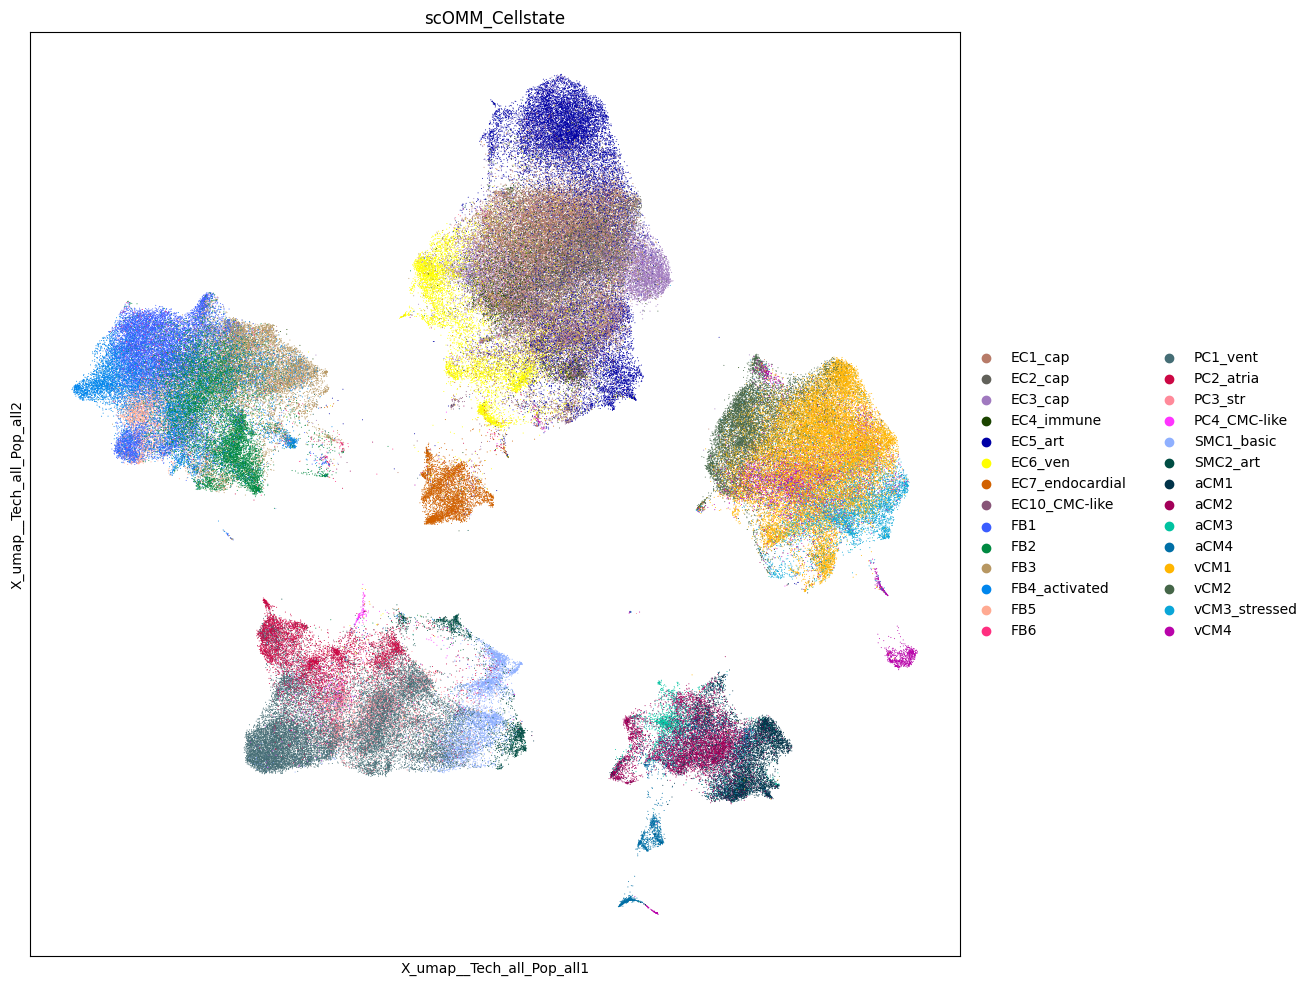

Figure size= (18, 18) dpi= 100.0 Scale factor = 40.94304701959345


/home/macera/.conda/envs/scanpy_basic/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/macera/.conda/envs/scanpy_basic/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/tmp/ipykernel_238677/3880658012.py:102: RuntimeWarning: invalid value encountered in divide
  norm_direction = direction / np.linalg.norm(direction)


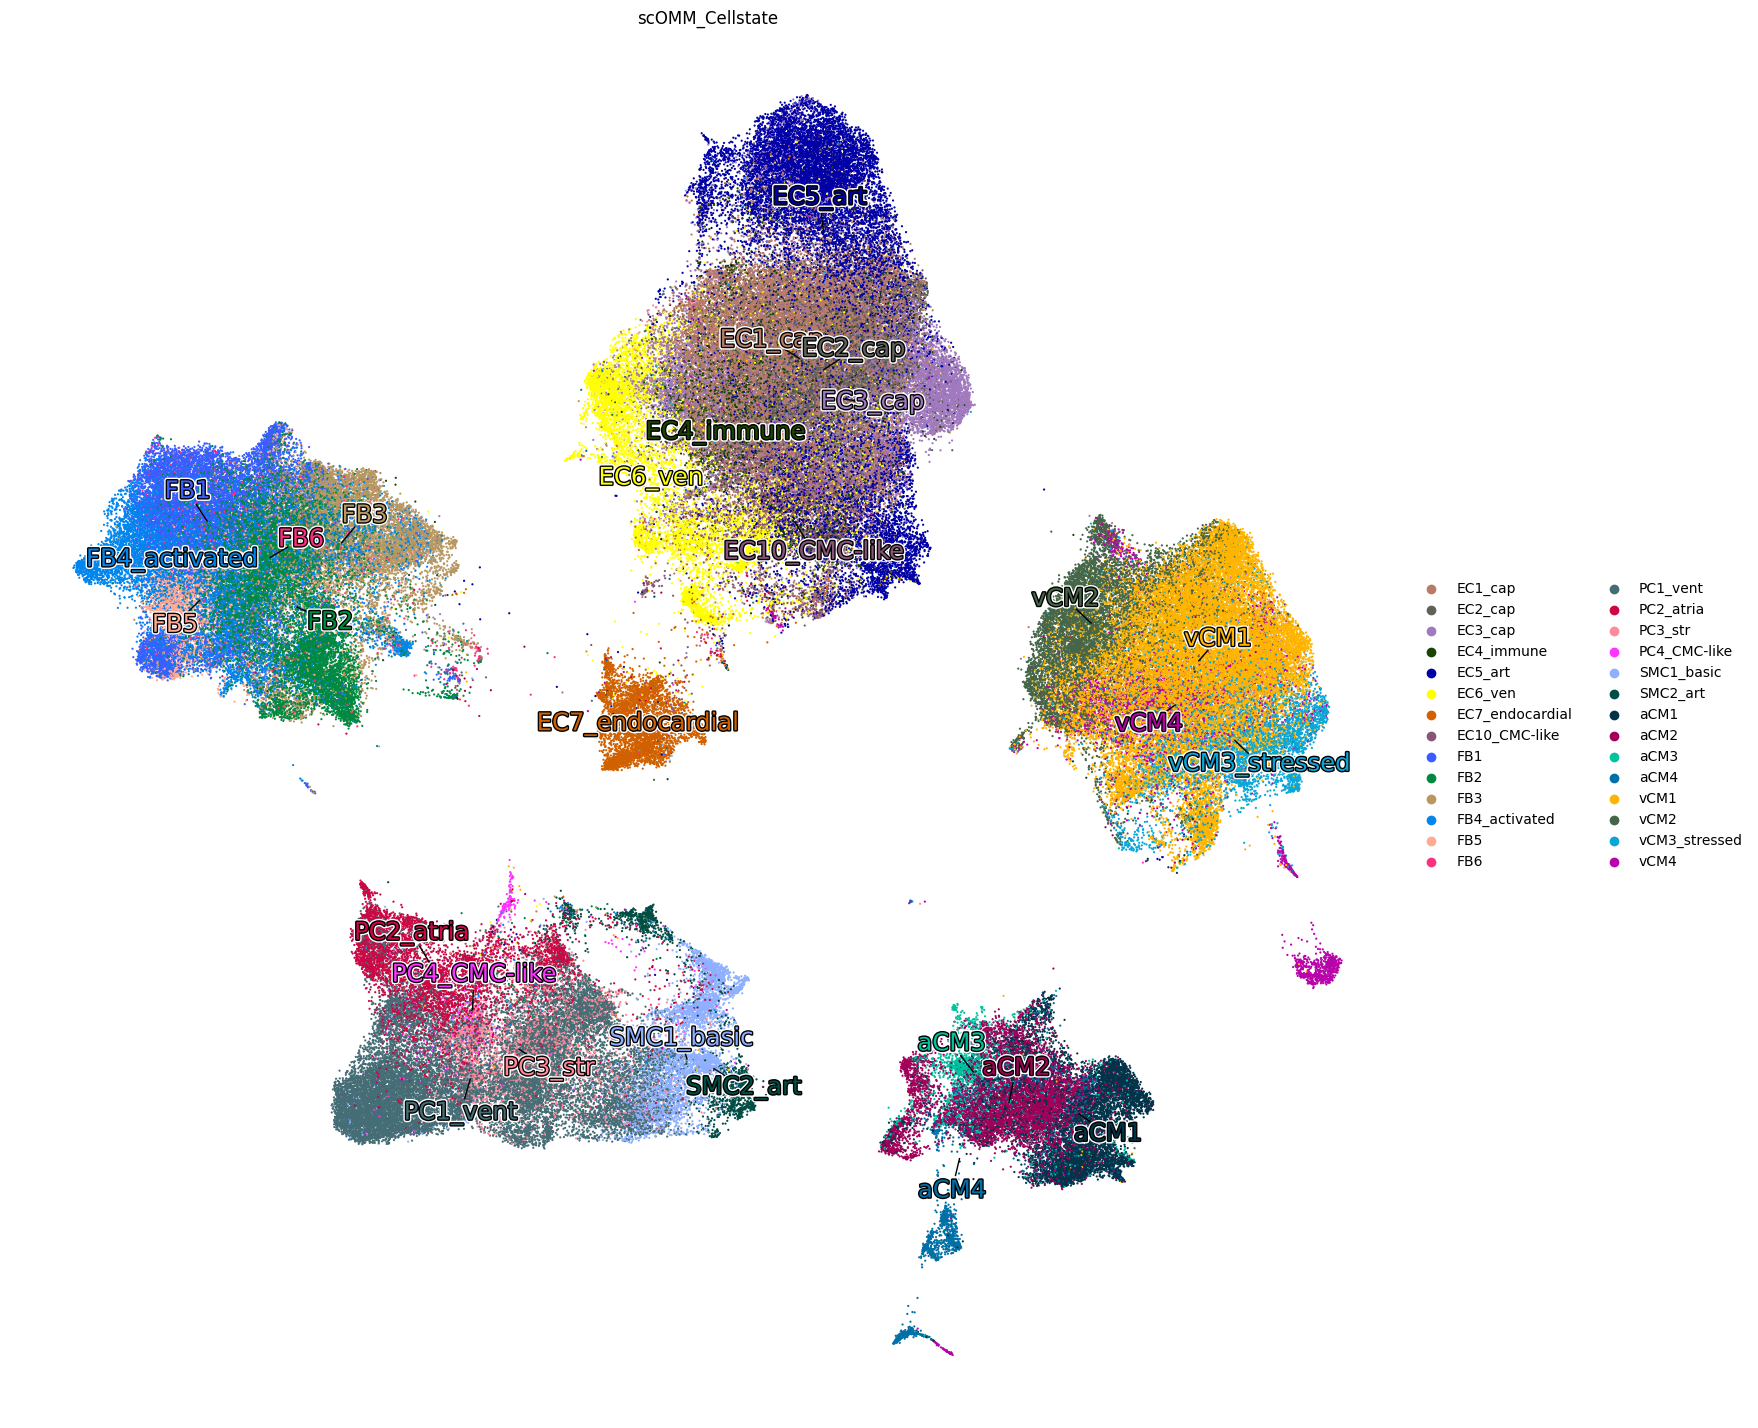

In [ ]:
# Random category→color assignment (no replacement), Scanpy-ready helper
from __future__ import annotations
from typing import Sequence, Dict, Iterable, Optional
import numpy as np
import pandas as pd
import anndata as ad

def random_color_map(
    categories: Sequence[str],
    colors: Sequence[str],
    seed: Optional[int] = None,
    exclude: Iterable[str] = (),
) -> Dict[str, str]:
    """
    Randomly assign each category a unique color (no replacement).
    - `colors` may be longer than `categories`.
    - `exclude` can list colors to avoid (e.g., already used elsewhere).
    - `seed` ensures reproducibility.
    """
    # De-duplicate colors while preserving order
    seen = set()
    colors_unique = []
    for c in colors:
        if c in exclude: 
            continue
        if c not in seen:
            colors_unique.append(c)
            seen.add(c)

    if len(colors_unique) < len(categories):
        raise ValueError(
            f"Not enough usable colors: need {len(categories)}, have {len(colors_unique)}."
        )

    rng = np.random.default_rng(seed)
    # sample indices without replacement
    idx = rng.choice(len(colors_unique), size=len(categories), replace=False)
    chosen = [colors_unique[i] for i in idx]
    return dict(zip(categories, chosen))


def write_scanpy_palette_random(
    adata: ad.AnnData,
    obs_col: str,
    colors: Sequence[str],
    seed: Optional[int] = None,
    exclude: Iterable[str] = (),
) -> Dict[str, str]:
    """
    Create a random palette for the categories in adata.obs[obs_col] and
    write it into adata.uns[f"{obs_col}_colors"] in the category order.
    Returns the {category: color} dict.
    """
    if obs_col not in adata.obs:
        raise KeyError(f"'{obs_col}' not in adata.obs.")
    if not isinstance(adata.obs[obs_col].dtype, pd.CategoricalDtype):
        # enforce categorical with stable ordering by sorted unique
        cats = pd.Categorical(adata.obs[obs_col]).categories.tolist()
        adata.obs[obs_col] = pd.Categorical(adata.obs[obs_col], categories=cats)
    cats = list(adata.obs[obs_col].cat.categories)

    cmap = random_color_map(cats, colors, seed=seed, exclude=exclude)
    # write list in *category order* (as Scanpy expects)
    adata.uns[f"{obs_col}_colors"] = [cmap[c] for c in cats]
    return cmap


# -----------------------------

import numpy as np


long_color_list = [

'#ffff00',
 '#1ce6ff',
 '#ff34ff',
 '#ff4a46',
 '#008941',
 '#006fa6',
 '#a30059',
 '#7a4900',
 '#0000a6',
#  '#63ffac',
 '#b79762',
 '#004d43',
 '#8fb0ff',
 '#5a0007',
 "#090909",
 '#1b4400',
 '#4fc601',
 '#3b5dff',
#  '#4a3b53',
 '#ff2f80',
 '#61615a',
 '#ba0900',
#  '#6b7900',
 '#00c2a0',
 '#ffaa92',
#  '#ff90c9',
 '#b903aa',
 '#d16100',
#  "#010102",
 '#7b4f4b',
 '#a1c299',
#  '#300018',
 '#0aa6d8',
 '#013349',
 '#00846f',
#  '#372101',
 '#ffb500',
 '#a079bf',
 '#cc0744',
#  '#c0b9b2',
#  '#001e09',
 '#00489c',
#  '#6f0062',
 '#0cbd66',
#  '#eec3ff',
 '#456d75',
 '#b77b68',
 '#788d66',
 '#885578',
#  '#fad09f',
 '#ff8a9a',
 '#d157a0',
#  '#bec459',
 '#456648',
 '#0086ed',
 '#886f4c',
#  '#3/4362d',
 '#00a6aa',
#  '#452c2c',
 '#636375',
 '#ff913f',
#  '#d3d3d3'
 ]

cmap = write_scanpy_palette_random(
    adata, "scOMM_Cellstate", long_color_list, seed=4567
)
print("Assigned colors:", cmap)
print("Scanpy palette length:", len(adata.uns["scOMM_Cellstate_colors"]))
sc.pl.embedding(adata,basis='X_umap__Tech_all_Pop_all', color='scOMM_Cellstate', size=2, palette=cmap)
umap_refined(adata,
                'X_umap__Tech_all_Pop_all',
                'scOMM_Cellstate',
                 size=10,
                label_size = 70,
                width_in_inches = 18,
                height_in_inches = 18,
                max_iterations=20,
                displacement=0.5)
plt.savefig('../figures/umap_horizontal_rna.png', dpi=400, bbox_inches='tight')

Figure size= (18, 18) dpi= 100.0 Scale factor = 40.94304701959345


/home/macera/.conda/envs/scanpy_basic/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/macera/.conda/envs/scanpy_basic/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/tmp/ipykernel_238677/3880658012.py:102: RuntimeWarning: invalid value encountered in divide
  norm_direction = direction / np.linalg.norm(direction)


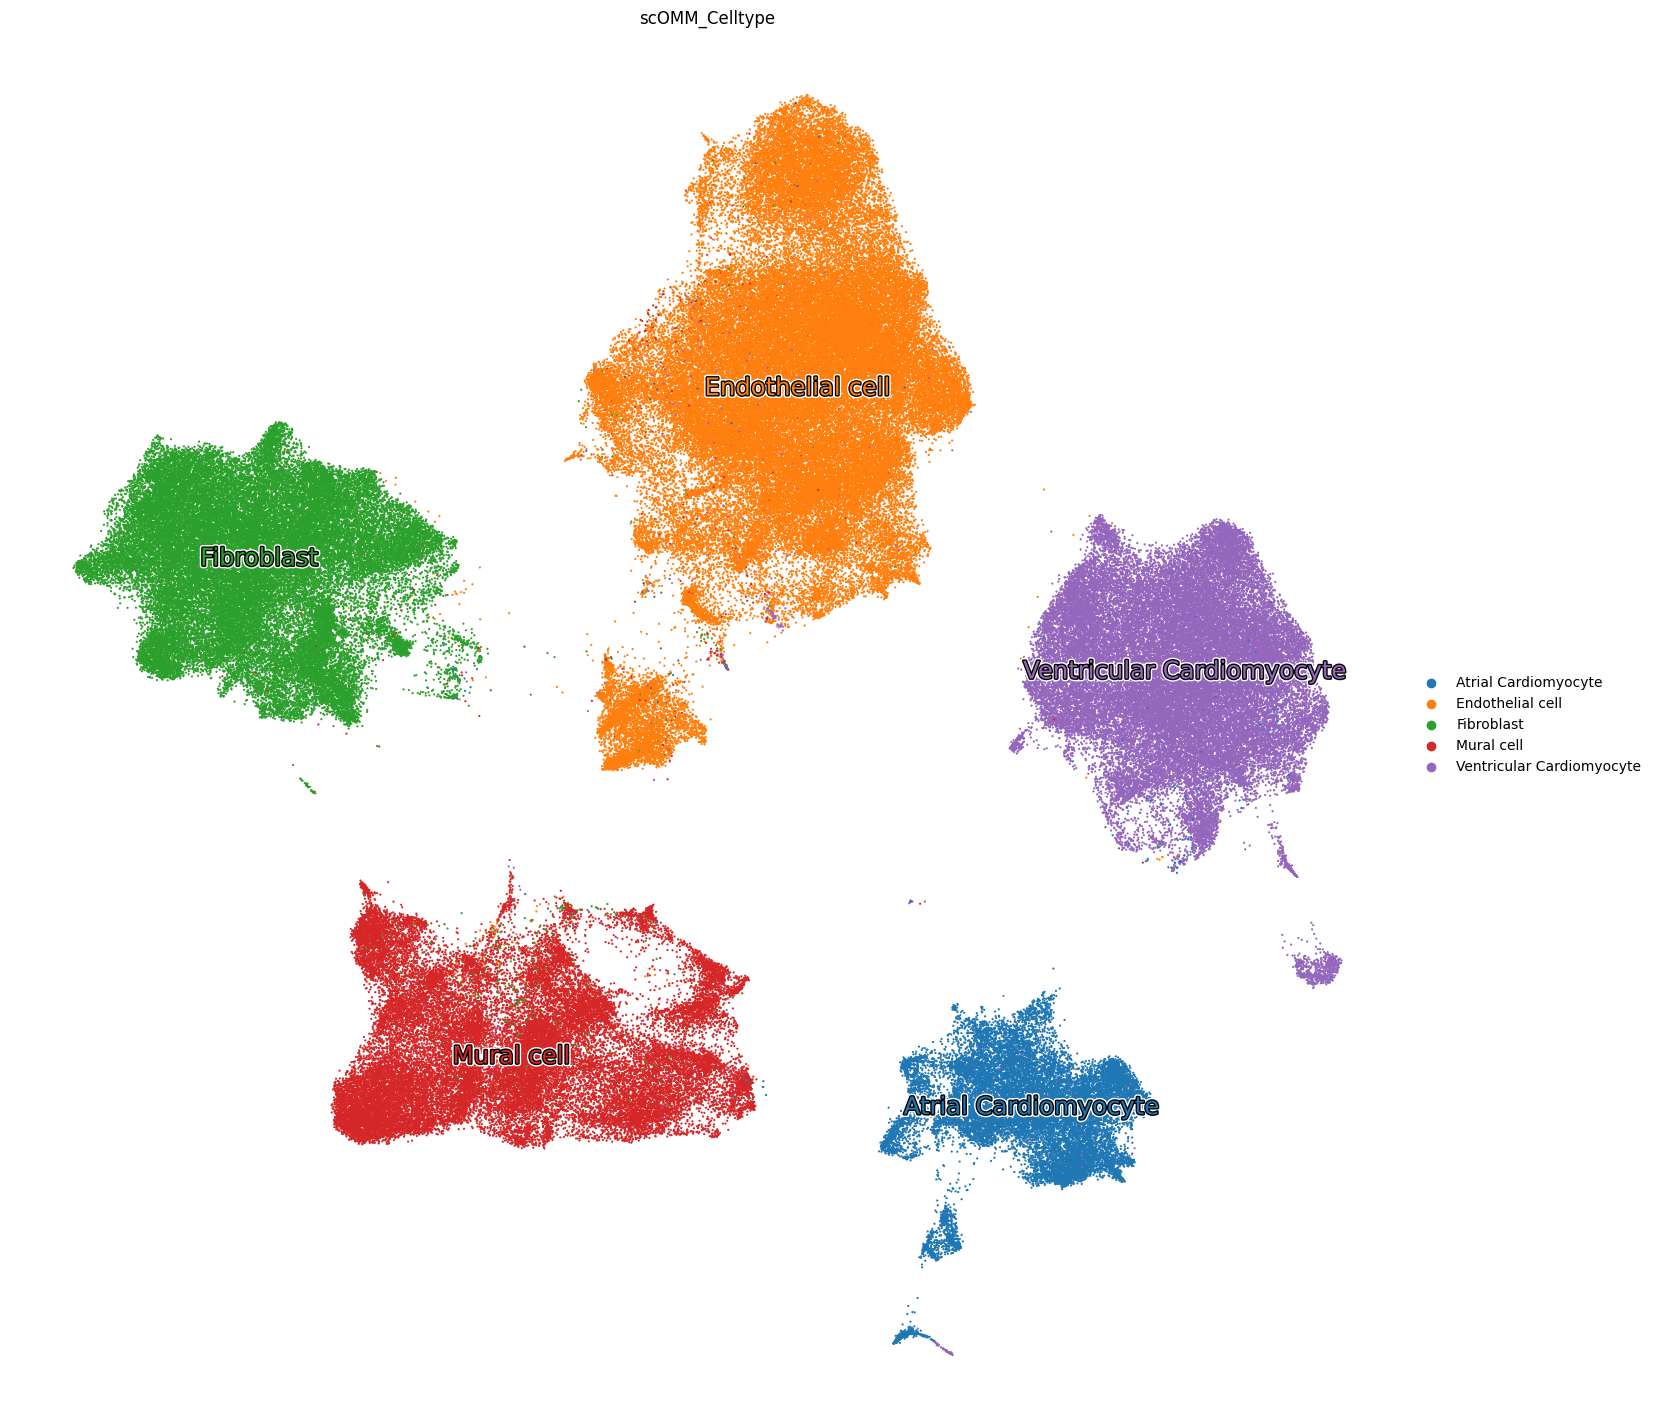

In [ ]:
umap_refined(adata,
                'X_umap__Tech_all_Pop_all',
                'scOMM_Celltype',
                 size=10,
                label_size = 70,
                width_in_inches = 18,
                height_in_inches = 18,
                max_iterations=20,
                displacement=0.5)
plt.savefig('../figures/umap_horizontal_rna_ct.png', dpi=400, bbox_inches='tight')

/home/macera/.conda/envs/scanpy_basic/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/macera/.conda/envs/scanpy_basic/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


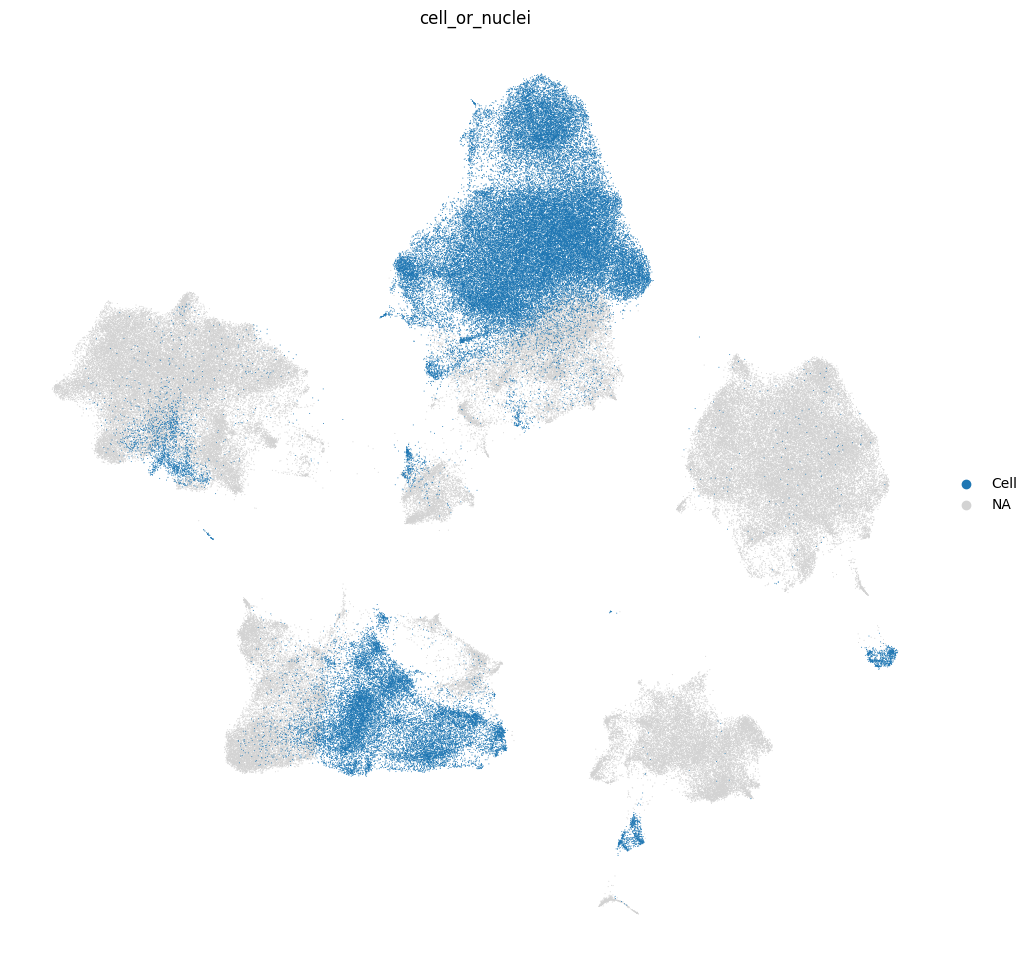

In [ ]:
sc.pl.embedding(adata,basis='X_umap__Tech_all_Pop_all', color='cell_or_nuclei', size=2,groups=['Cell'], frameon=False, show=False)
plt.savefig('../figures/umap_horizontal_rna_suspension_cell.png', dpi=400, bbox_inches='tight')

/home/macera/.conda/envs/scanpy_basic/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/macera/.conda/envs/scanpy_basic/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


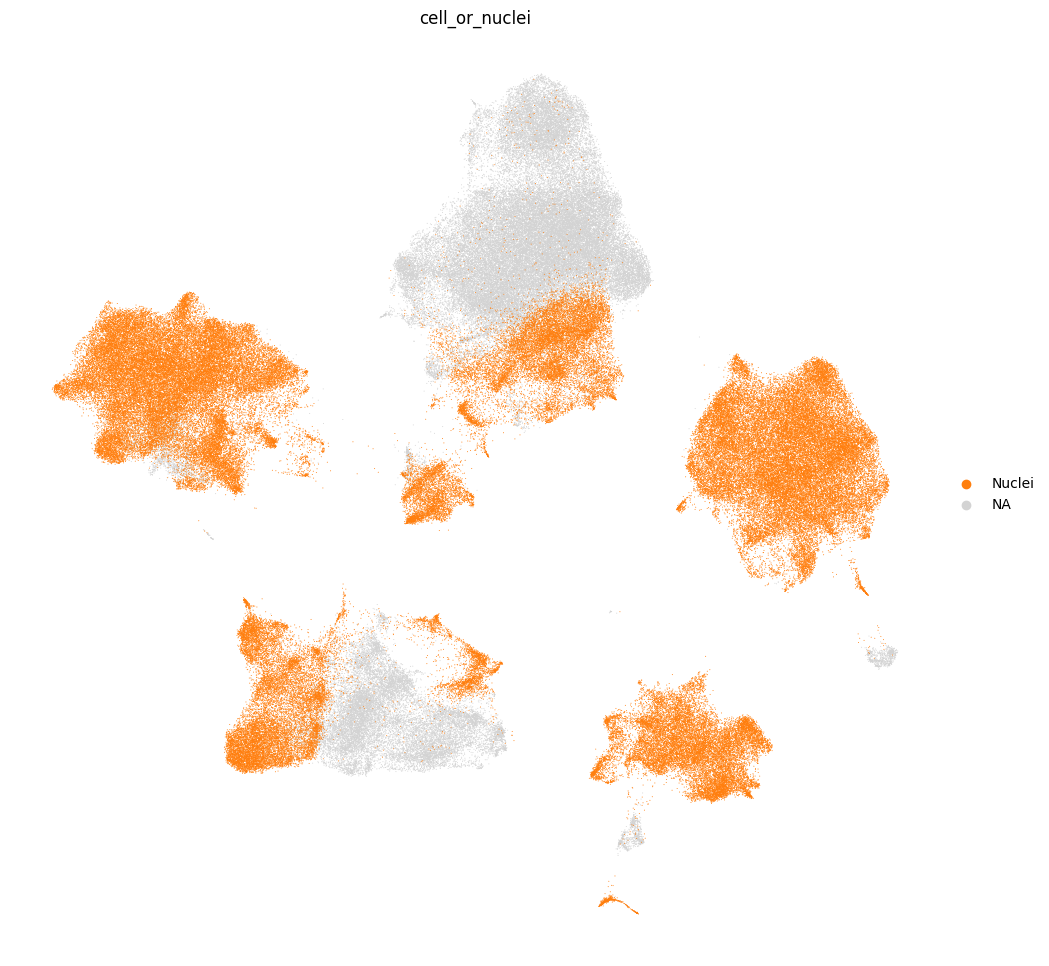

In [ ]:
sc.pl.embedding(adata,basis='X_umap__Tech_all_Pop_all', color='cell_or_nuclei', size=2,groups=['Nuclei'], frameon=False, show=False)
plt.savefig('../figures/umap_horizontal_rna_suspension_nucleus.png', dpi=400, bbox_inches='tight')

/home/macera/.conda/envs/scanpy_basic/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/macera/.conda/envs/scanpy_basic/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


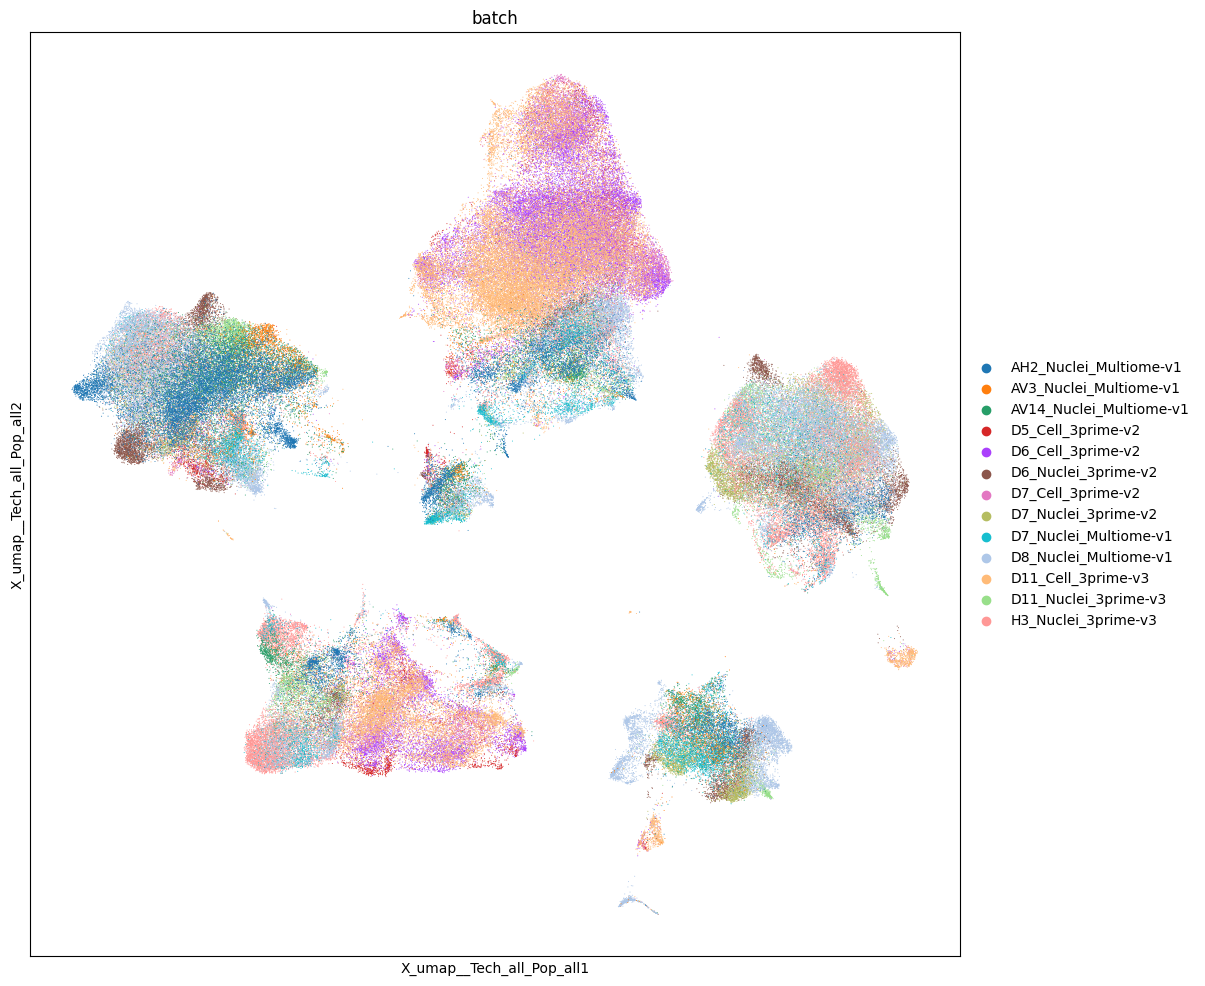

In [ ]:
sc.pl.embedding(adata,basis='X_umap__Tech_all_Pop_all', color='batch', size=2,  show=False)
plt.savefig('../figures/umap_horizontal_rna_suspension.png', dpi=400, bbox_inches='tight')

In [ ]:
adata.obs['kit_10x'].value_counts()

kit_10x
3prime-v3      79807
3prime-v2      75685
Multiome-v1    74129
Name: count, dtype: int64

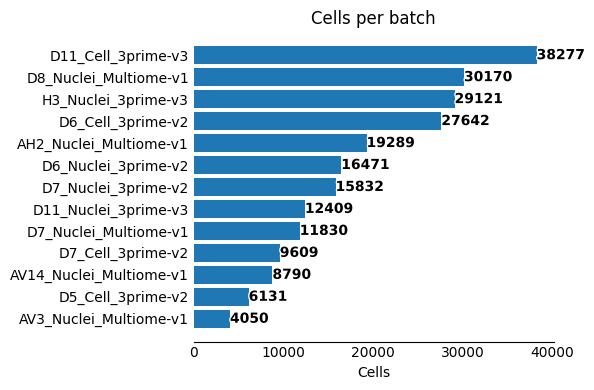

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe

def plot_obs_counts(
    adata,
    key: str = "batch",
    normalize: bool = False,     # plot percentages instead of counts
    include_na: bool = True,     # include NaN as a category
    sort: bool = True,           # sort by frequency (desc)
    top_n: int | None = None,    # keep only top-N categories
    orientation: str = "auto",   # "v" | "h" | "auto"
    annotate: bool = True,       # write values on bars
    title: str | None = None,
):
    s = adata.obs[key]
    if include_na:
        s = s.fillna("NA")
    counts = s.value_counts(dropna=False)
    if normalize:
        data = 100 * counts / counts.sum()
        ylab = "Percent"
    else:
        data = counts
        ylab = "Cells"

    if sort:
        data = data.sort_values(ascending=False)
    if top_n is not None:
        data = data.head(top_n)

    n = len(data)
    if orientation == "auto":
        orientation = "h" if n > 12 else "v"

    # Figure size scales with number of categories
    if orientation == "v":
        fig, ax = plt.subplots(figsize=(max(6, 0.6 * n), 4))
        bars = ax.bar(range(n), data.values)
        ax.set_xticks(range(n))
        ax.set_xticklabels(data.index, rotation=45, ha="right")
        ax.set_ylabel(ylab)
        ax.set_title(title or f"{ylab} per {key}")
        if annotate:
            for i, b in enumerate(bars):
                val = data.values[i]
                txt = f"{val:.1f}%" if normalize else f"{int(val)}"
                t = ax.text(
                    b.get_x() + b.get_width() / 2,
                    b.get_height(),
                    txt,
                    ha="center",
                    va="bottom",
                    fontweight="bold",
                    color="black",
                )
                t.set_path_effects([pe.Stroke(linewidth=2.0, foreground="white"), pe.Normal()])
    else:
        fig, ax = plt.subplots(figsize=(max(6, 0.22 * n), max(4, 0.3 * n)))
        bars = ax.barh(range(n), data.values)
        ax.set_yticks(range(n))
        ax.set_yticklabels(data.index)
        ax.invert_yaxis()  # largest on top (if sorted)
        ax.set_xlabel(ylab)
        ax.set_title(title or f"{ylab} per {key}")
        if annotate:
            for i, b in enumerate(bars):
                val = data.values[i]
                txt = f"{val:.1f}%" if normalize else f"{int(val)}"
                x = b.get_width()
                t = ax.text(
                    x, b.get_y() + b.get_height() / 2,
                    txt,
                    va="center",
                    ha="left",
                    fontweight="bold",
                    color="black",
                )
                t.set_path_effects([pe.Stroke(linewidth=2.0, foreground="white"), pe.Normal()])
        # Add a bit of right margin for labels
        right_lim = max(data.values) * (1.10 if normalize else 1.05)
        for side in ["top", "right", "left"]:
            ax.spines[side].set_visible(False)
        ax.tick_params(axis="both", length=0)
        ax.set_xlim(0, right_lim)

    plt.tight_layout()
    # plt.show()
    return fig, ax

# --- Usage ---
plot_obs_counts(adata, key="batch", normalize=False, include_na=True)
plt.savefig('../figures/barplot.png', dpi=400, bbox_inches='tight')

In [ ]:
import numpy as np
import pandas as pd
from typing import List, Optional, Tuple, Dict

# -------------------------------
# 1) Construcción de la tabla
# -------------------------------

def build_prepost_table_from_obs(
    adata,
    *,
    metric_base: str,                  # "silhouette" | "binary_lisi"
    label_key: str,                    # e.g., "scOMM_Celltype" | "scOMM_Cellstate"
    tech_key: str = "Tech",
    tech_list: List[str] = (),
    include_pre_all: bool = True,
    min_cells: int = 10,
    drop_empty_labels: bool = True,
) -> Tuple[pd.DataFrame, pd.DataFrame, Dict[str, str]]:
    """
    Construye una matriz PRE/POST intercalada a partir de columnas en `adata.obs`
    siguiendo los patrones de nombre acordados.

    Columnas de salida (en este orden):
      [ PRE_<tech1>, POST_<tech1>, PRE_<tech2>, POST_<tech2>, ..., (opcional) PRE_ALL ]

    Para cada celda (label, columna) se calcula la media de la métrica sobre
    el subconjunto correspondiente y se registra el número de celdas (counts).
    Si counts < min_cells, el valor se pone a NaN.

    Devuelve:
      - matrix: DataFrame (rows = labels, cols = columnas PRE/POST intercaladas)
      - counts: DataFrame del mismo shape con números de celdas usados
      - used_cols: dict con los nombres de columnas de `adata.obs` realmente usados:
           {
             "PRE__<tech>": "<obs_col_name>",
             "POST__<tech>": "<obs_col_name>",
             "PRE__ALL": "<obs_col_name>" (si aplica)
           }
    """
    obs = adata.obs
    if label_key not in obs.columns:
        raise KeyError(f"'{label_key}' not in adata.obs")
    if tech_key not in obs.columns:
        raise KeyError(f"'{tech_key}' not in adata.obs")

    # Resolver nombres esperados en adata.obs
    def pre_col_name(tech: str) -> str:
        return f"{metric_base}__PRE__Tech_{tech}_Pop_all__{label_key}"

    def post_col_name_for_tech(tech: str) -> str:
        return f"{metric_base}__POST__Tech_all_Pop_all__{label_key}__Tech={tech}"

    def pre_all_col_name() -> str:
        return f"{metric_base}__PRE__Tech_all_Pop_all__{label_key}"

    # Labels ordenadas (categorical si existe)
    labels = obs[label_key]
    if pd.api.types.is_categorical_dtype(labels):
        row_index = list(labels.cat.categories)
    else:
        row_index = sorted(pd.unique(labels.astype(str)))

    # Crear contenedores
    cols_vals = []
    cols_cnts = []
    used_cols: Dict[str, str] = {}

    # Construir pares intercalados PRE/POST por tecnología
    for tech in tech_list:
        # Máscaras por tecnología y por label se aplican al agregar.
        # PRE_<tech>
        pre_obs_col = pre_col_name(tech)
        if pre_obs_col in obs.columns:
            used_cols[f"PRE__{tech}"] = pre_obs_col
            pre_series = obs[pre_obs_col]
        else:
            used_cols[f"PRE__{tech}"] = None
            pre_series = pd.Series(np.nan, index=obs.index, name=pre_obs_col)

        # POST_<tech>
        post_obs_col = post_col_name_for_tech(tech)
        if post_obs_col in obs.columns:
            used_cols[f"POST__{tech}"] = post_obs_col
            post_series = obs[post_obs_col]
        else:
            used_cols[f"POST__{tech}"] = None
            post_series = pd.Series(np.nan, index=obs.index, name=post_obs_col)

        # Agregaciones por label para PRE y POST (sólo celdas de esa tecnología)
        tech_mask = (obs[tech_key].astype(str) == str(tech))

        def agg_by_label(series: pd.Series, label_values: pd.Series) -> Tuple[pd.Series, pd.Series]:
            # filtra por tech y elimina NaN (métrica puede ser NaN fuera del subset original)
            s = series[tech_mask]
            lv = label_values[tech_mask]
            grp = pd.concat({"val": s, "lab": lv}, axis=1).dropna(subset=["val"])
            if grp.empty:
                mean = pd.Series(np.nan, index=row_index, name=None)
                cnt = pd.Series(0, index=row_index, name=None, dtype=int)
                return mean, cnt
            mean = grp.groupby("lab", observed=True)["val"].mean()
            cnt = grp.groupby("lab", observed=True)["val"].size().astype(int)
            # reindex a todas las labels (rellena NaN / 0)
            mean = mean.reindex(row_index)
            cnt = cnt.reindex(row_index).fillna(0).astype(int)
            # aplicar min_cells
            mean = mean.mask(cnt < min_cells, np.nan)
            cnt = cnt.mask(cnt < min_cells, np.nan)
            return mean, cnt

        pre_mean, pre_cnt = agg_by_label(pre_series, labels)
        post_mean, post_cnt = agg_by_label(post_series, labels)

        cols_vals.append(pre_mean.rename(f"PRE_{tech}"))
        cols_cnts.append(pre_cnt.rename(f"PRE_{tech}"))
        cols_vals.append(post_mean.rename(f"POST_{tech}"))
        cols_cnts.append(post_cnt.rename(f"POST_{tech}"))

    # PRE_ALL (al final)
    if include_pre_all:
        pre_all_col = pre_all_col_name()
        if pre_all_col in obs.columns:
            used_cols["PRE__ALL"] = pre_all_col
            series = obs[pre_all_col]
            grp = pd.concat({"val": series, "lab": labels}, axis=1).dropna(subset=["val"])
            if grp.empty:
                pre_all_mean = pd.Series(np.nan, index=row_index, name="PRE_ALL")
                pre_all_cnt = pd.Series(np.nan, index=row_index, name="PRE_ALL")
            else:
                pre_all_mean = grp.groupby("lab", observed=True)["val"].mean().reindex(row_index)
                pre_all_cnt = grp.groupby("lab", observed=True)["val"].size().reindex(row_index).astype(float)
                # min_cells global (across ALL techs previos a integración)
                pre_all_mean = pre_all_mean.mask(pre_all_cnt < min_cells, np.nan)
                pre_all_cnt = pre_all_cnt.mask(pre_all_cnt < min_cells, np.nan)
        else:
            used_cols["PRE__ALL"] = None
            pre_all_mean = pd.Series(np.nan, index=row_index, name="PRE_ALL")
            pre_all_cnt = pd.Series(np.nan, index=row_index, name="PRE_ALL")

        cols_vals.append(pre_all_mean.rename("Overall POST"))
        cols_cnts.append(pre_all_cnt.rename("Overall POST"))

    # Construir matrices finales
    matrix = pd.concat(cols_vals, axis=1)
    counts = pd.concat(cols_cnts, axis=1)

    # Opcional: eliminar filas sin datos
    if drop_empty_labels:
        all_nan = matrix.isna().all(axis=1)
        matrix = matrix.loc[~all_nan]
        counts = counts.loc[~all_nan]

    return matrix, counts, used_cols


# -------------------------------
# 2) Heatmap
# -------------------------------

def plot_metric_heatmap(
    matrix: pd.DataFrame,
    counts: Optional[pd.DataFrame] = None,
    *,
    metric_base: str = "silhouette",   # "silhouette" | "binary_lisi"
    title: Optional[str] = None,
    annotate: bool = True,
    fmt: str = ".2f",
    figsize_scale: float = 1,
):
    """
    Dibuja un heatmap a partir de la matriz construida arriba.
    - 'silhouette' usa escala [-1, 1] centrada en 0.
    - 'binary_lisi' usa escala [0, 1].
    """
    import seaborn as sns
    import matplotlib.pyplot as plt

    mat = matrix.copy()
    if metric_base.lower() == "silhouette":
        vmin, vmax, center, cmap, cbar = -1.0, 1.0, 0.0, "Blues", "Mean silhouette"
        vmin=np.min(mat)
        vmax=np.max(mat)

    else:
        vmin, vmax, center, cmap, cbar = 0.0, 1.0, None, "Greens", "Mean binary LISI"
        vmin=np.min(mat)
        vmax=np.max(mat)


    plt.figure(figsize=(max(8, 1 + figsize_scale * mat.shape[1]), max(6, 0.4 * mat.shape[0])))
    ax = sns.heatmap(
        mat, cmap=cmap, vmin=vmin, vmax=vmax, center=center,
        annot=False, linewidths=0.5, linecolor="white",
        cbar_kws={"label": cbar}
    )
    if title:
        ax.set_title(title, fontsize=12)

    if annotate:
        for i in range(mat.shape[0]):
            for j in range(mat.shape[1]):
                val = mat.iat[i, j]
                if np.isfinite(val):
                    text = format(val, fmt)
                    if counts is not None and counts.shape == mat.shape:
                        n = counts.iat[i, j]
                        if pd.notna(n):
                            text = f"{text}\n(n={int(n)})"
                    ax.text(j + 0.5, i + 0.5, text,
                            ha="center", va="center", fontsize=8, color="black")

    plt.xticks(rotation=45, ha="right"); plt.yticks(rotation=0)
    plt.tight_layout()
    # plt.show()


In [ ]:
def _sanitize_uns(x):
    if isinstance(x, tuple):
        return list(x)
    if isinstance(x, set):
        return list(x)
    if isinstance(x, dict):
        return {k: _sanitize_uns(v) for k, v in x.items()}
    if isinstance(x, list):
        return [_sanitize_uns(v) for v in x]
    return x

adata.uns = _sanitize_uns(dict(adata.uns))
adata.write("objects/rna_metrics.h5ad", compression="gzip")

... storing 'scOMM_Celltype' as categorical
... storing 'scOMM_Cellstate' as categorical


## METRICS

In [ ]:
RUN_UMAPS = False
csv_dir = Path(CSV_DIR)
csv_files = sorted(csv_dir.glob(CSV_GLOB))
assert len(csv_files) > 0, f"No CSVs found in {csv_dir} with pattern {CSV_GLOB}"
logging.info(f"Found {len(csv_files)} CSV files.")

if EXPORT_UMAP_CSV:
    Path(UMAP_CSV_DIR).mkdir(parents=True, exist_ok=True)

for csv_path in csv_files[1:]:
    key = key_from_filename(csv_path)
    logging.info(f"[{key}] Reading {csv_path.name}")
    df = read_latent_csv(csv_path)

    # intersect with AnnData
    overlap = df.index.intersection(adata.obs_names)
    if overlap.empty:
        logging.warning(f"[{key}] No overlapping barcodes. Skipping.")
        continue
    df = df.loc[overlap]

    logging.info(f"[{key}] Attaching latent (cells={df.shape[0]}, dims={df.shape[1]})")
    full_latent = attach_latent_as_obsm(adata, df, key)

    logging.info(f"[{key}] Computing UMAP on subset")
    if RUN_UMAPS:
        neighbors_umap_from_latent_subset(
            adata=adata,
            full_latent=full_latent,
            key=key,
            n_neighbors=15,
            min_dist=0.3,
            spread=2.0,
            metric="euclidean",
            random_state=0,
            store_graph=False,  # True si quieres dist/connectivities
        )

    # 2) Métricas para distintas anotaciones, reusando los mismos vecinos:
    metrics_from_stored_neighbors(
        adata=adata,
        full_latent=full_latent,                 # e.g., adata.obsm["X_scVI__Tech_Cell_3prime-v2_Pop_all"]
        label_key="scOMM_Celltype",
        key=key,                                 # e.g., "Tech_Cell_3prime-v2_Pop_all"
        compute=("binary_lisi", "silhouette"),
        phase="PRE",                             # <<< naming
    )
    metrics_from_stored_neighbors(
        adata=adata,
        full_latent=adata.obsm["X_scVI__Tech_all_Pop_all"],
        label_key="scOMM_Celltype",
        key="Tech_all_Pop_all",
        compute=("binary_lisi", "silhouette"),
        phase="POST",                            # <<< naming
        group_key_for_silhouette="Tech",         # per-Tech silhouette
        group_key_for_lisi="Tech",               # per-Tech LISI (use same latent)
        lisi_neighbor_strategy="recompute",      # constant k within tech
    )
    metrics_from_stored_neighbors(
        adata=adata,
        full_latent=full_latent,                 # e.g., adata.obsm["X_scVI__Tech_Cell_3prime-v2_Pop_all"]
        label_key="scOMM_Cellstate",
        key=key,                                 # e.g., "Tech_Cell_3prime-v2_Pop_all"
        compute=("binary_lisi", "silhouette"),
        phase="PRE",                             # <<< naming
    )
    metrics_from_stored_neighbors(
        adata=adata,
        full_latent=adata.obsm["X_scVI__Tech_all_Pop_all"],
        label_key="scOMM_Cellstate",
        key="Tech_all_Pop_all",
        compute=("binary_lisi", "silhouette"),
        phase="POST",                            # <<< naming
        group_key_for_silhouette="Tech",         # per-Tech silhouette
        group_key_for_lisi="Tech",               # per-Tech LISI (use same latent)
        lisi_neighbor_strategy="recompute",      # constant k within tech
    )

2025-08-21 11:31:42,350 | INFO | Found 6 CSV files.
2025-08-21 11:31:42,352 | INFO | [Tech_Cell_3prime-v3_Pop_all] Reading Tech_Cell_3prime-v3_Pop_all_scVI.csv
2025-08-21 11:31:42,962 | INFO | [Tech_Cell_3prime-v3_Pop_all] Attaching latent (cells=38277, dims=50)
2025-08-21 11:31:43,066 | INFO | [Tech_Cell_3prime-v3_Pop_all] Computing UMAP on subset
2025-08-21 11:41:56,677 | INFO | [Tech_Nuclei_3prime-v2_Pop_all] Reading Tech_Nuclei_3prime-v2_Pop_all_scVI.csv
2025-08-21 11:41:56,940 | INFO | [Tech_Nuclei_3prime-v2_Pop_all] Attaching latent (cells=32303, dims=50)
2025-08-21 11:41:56,996 | INFO | [Tech_Nuclei_3prime-v2_Pop_all] Computing UMAP on subset
2025-08-21 11:51:45,479 | INFO | [Tech_Nuclei_3prime-v3_Pop_all] Reading Tech_Nuclei_3prime-v3_Pop_all_scVI.csv
2025-08-21 11:51:45,873 | INFO | [Tech_Nuclei_3prime-v3_Pop_all] Attaching latent (cells=41530, dims=50)
2025-08-21 11:51:45,989 | INFO | [Tech_Nuclei_3prime-v3_Pop_all] Computing UMAP on subset
2025-08-21 12:01:01,808 | INFO | [T

In [ ]:
def _sanitize_uns(x):
    if isinstance(x, tuple):
        return list(x)
    if isinstance(x, set):
        return list(x)
    if isinstance(x, dict):
        return {k: _sanitize_uns(v) for k, v in x.items()}
    if isinstance(x, list):
        return [_sanitize_uns(v) for v in x]
    return x

adata.uns = _sanitize_uns(dict(adata.uns))
adata.write("objects/rna_metrics.h5ad", compression="gzip")

In [ ]:
techs = ['Cell_3prime-v2', 'Cell_3prime-v3', 'Nuclei_3prime-v2', 'Nuclei_3prime-v3', 'Nuclei_Multiome-v1']
for metric_base in ['silhouette','binary_lisi']:
    for ann in ['scOMM_Celltype','scOMM_Cellstate']:

        # 1) Silhouette con cell type (PRE/POST intercalado y PRE_ALL al final)
        sil_mat, sil_cnt, used_cols_sil = build_prepost_table_from_obs(
            adata,
            metric_base=metric_base,
            label_key=ann,
            tech_key="Tech",
            tech_list=techs,
            include_pre_all=True,
            min_cells=10,
        )

        plot_metric_heatmap(
            sil_mat, counts=sil_cnt,
            metric_base=metric_base,
            title=f"PRE vs POST Integration metrics | metric = {metric_base} — label = {ann}",
        )
        plt.savefig(f'figs/heatmap_metrics/{ann}_{metric_base}.png', bbox_inches='tight', dpi=400)
        plt.savefig(f'figs/heatmap_metrics/{ann}_{metric_base}.pdf', bbox_inches='tight', dpi=400)

        plt.close()
        if ann=='scOMM_Cellstate':
            for ct in adata.obs['scOMM_Celltype'].unique():
                sil_mat, sil_cnt, used_cols_sil = build_prepost_table_from_obs(
                    adata[adata.obs['scOMM_Celltype']==ct],
                    metric_base=metric_base,
                    label_key=ann,
                    tech_key="Tech",
                    tech_list=techs,
                    include_pre_all=True,
                    min_cells=10,
                )

                plot_metric_heatmap(
                    sil_mat, counts=sil_cnt,
                    metric_base=metric_base,
                    title=f"PRE vs POST Integration metrics | metric = {metric_base} — label = {ann} - Celltype: {ct}",
                )

                plt.savefig(f'figs/heatmap_metrics/{ann}_{metric_base}_subset_{ct}.png', bbox_inches='tight', dpi=400)
                plt.savefig(f'figs/heatmap_metrics/{ann}_{metric_base}_subset_{ct}.pdf', bbox_inches='tight', dpi=400)

                plt.close()


/tmp/ipykernel_24701/530557293.py:59: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(labels):
2025-08-21 15:30:26,883 | INFO | maxp pruned
2025-08-21 15:30:26,895 | INFO | cmap pruned
2025-08-21 15:30:26,896 | INFO | kern dropped
2025-08-21 15:30:26,896 | INFO | post pruned
2025-08-21 15:30:26,897 | INFO | FFTM dropped
2025-08-21 15:30:26,899 | INFO | GPOS pruned
2025-08-21 15:30:26,907 | INFO | GSUB pruned
2025-08-21 15:30:26,921 | INFO | glyf pruned
2025-08-21 15:30:26,924 | INFO | Added gid0 to subset
2025-08-21 15:30:26,925 | INFO | Added first four glyphs to subset
2025-08-21 15:30:26,925 | INFO | Closing glyph list over 'GSUB': 54 glyphs before
2025-08-21 15:30:26,926 | INFO | Glyph names: ['.notdef', '.null', 'A', 'C', 'E', 'F', 'I', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'V', 'a', 'b', 'bar', 'c', 'd', 'e', 'eight', 'emdash', 'equal', 'five', 'f

In [ ]:
import numpy as np
import pandas as pd
from typing import Dict, List, Optional, Tuple

def collapse_by_tech_groups(
    matrix: pd.DataFrame,
    counts: Optional[pd.DataFrame],
    *,
    group_defs: Dict[str, List[str]],       # {"3’scRNA-seq": [...], "3’snRNA-seq": [...]}
    phase: str = "POST",                    # "PRE" | "POST"  -> qué columnas colapsar (p.ej. POST_* o PRE_*)
    include_all: bool = True,               # añade columna "ALL" (tomada de PRE_ALL si existe; si no, omitida)
    min_cells_group: Optional[int] = None,  # si se da, apaga filas con total < min_cells_group por grupo
) -> Tuple[pd.DataFrame, Optional[pd.DataFrame]]:
    """
    Colapsa columnas PRE_* o POST_* por familias tecnológicas, devolviendo una matriz
    con 2 columnas (una por grupo) y opcionalmente 'ALL'.

    - Pondera por 'counts' si está disponible; en su defecto, media simple.
    - Si include_all=True, busca 'PRE_ALL' en la matriz original y lo usa como 'ALL'.
    """
    phase = phase.upper()
    if phase not in {"PRE", "POST"}:
        raise ValueError("phase must be 'PRE' or 'POST'")

    # Seleccionar columnas del 'phase' a colapsar, por tecnología
    # Esperamos columnas llamadas "PRE_<tech>" o "POST_<tech>"
    def phase_col(tech: str) -> str:
        return f"{phase}_{tech}"

    out_vals = {}
    out_cnts = {}

    for gname, techs in group_defs.items():
        cols = [c for t in techs for c in [phase_col(t)] if c in matrix.columns]
        if len(cols) == 0:
            # grupo sin columnas -> NaNs
            out_vals[gname] = pd.Series(np.nan, index=matrix.index, name=gname)
            out_cnts[gname] = pd.Series(np.nan, index=matrix.index, name=gname)
            continue

        block = matrix[cols]
        if counts is not None and set(cols) <= set(counts.columns):
            cblock = counts[cols].astype(float)
            num = (block * cblock).sum(axis=1, skipna=True)
            den = cblock.sum(axis=1, skipna=True)
            val = np.divide(num, den, out=np.full_like(num, np.nan, dtype=float), where=den > 0)
            cnt = den  # total de celdas usadas
        else:
            val = block.mean(axis=1, skipna=True)
            cnt = block.notna().sum(axis=1)  # nº de techs válidas (no celdas)
        out_vals[gname] = val.rename(gname)
        out_cnts[gname] = cnt.rename(gname)

    # ALL (tercera columna opcional)
    if include_all:
        # Intentamos usar PRE_ALL si existe; si no, omitimos ALL silenciosamente
        if "HORIZONTAL INT" in matrix.columns:
            all_series = matrix["HORIZONTAL INT"]#.rename("ALL")
            out_vals["HORIZONTAL INT"] = all_series
            if counts is not None and "HORIZONTAL INT" in counts.columns:
                out_cnts["HORIZONTAL INT"] = counts["HORIZONTAL INT"]#.rename("ALL")
            else:
                out_cnts["HORIZONTAL INT"] = pd.Series(np.nan, index=matrix.index, name="ALL")

    # Construir dataframes
    mat = pd.concat(out_vals.values(), axis=1)
    cnt = pd.concat(out_cnts.values(), axis=1) if out_cnts else None

    # Filtro opcional por min_cells_group (apaga por fila/grupo si total < umbral)
    if min_cells_group is not None and cnt is not None:
        for col in mat.columns:
            bad = cnt[col] < float(min_cells_group)
            mat.loc[bad, col] = np.nan
            cnt.loc[bad, col] = np.nan

    # Eliminar filas totalmente vacías
    all_nan = mat.isna().all(axis=1)
    mat = mat.loc[~all_nan]
    if cnt is not None:
        cnt = cnt.loc[~all_nan]

    return mat, cnt


def plot_group_collapsed_heatmap(
    matrix: pd.DataFrame,
    counts: Optional[pd.DataFrame] = None,
    *,
    metric_base: str = "silhouette",    # "silhouette" | "binary_lisi"
    title: Optional[str] = None,
    annotate: bool = True,
    fmt: str = ".2f",
    figsize: Optional[Tuple[float, float]] = None,
):
    """Heatmap compacto para la matriz colapsada por grupos."""
    import seaborn as sns
    import matplotlib.pyplot as plt
    mat = matrix.copy()

    if metric_base.lower() == "silhouette":
        vmin, vmax, center, cmap, cbar = -1.0, 1.0, 0.0, "Blues", "Mean silhouette"
        vmin=np.min(mat)
        vmax=np.max(mat)

    else:
        vmin, vmax, center, cmap, cbar = 0.0, 1.0, None, "Greens", "Mean binary LISI"
        vmin=np.min(mat)
        vmax=np.max(mat)


    if figsize is None:
        figsize = (max(5, 1 + 1.2 * mat.shape[1]), max(5, 0.4 * mat.shape[0]))

    plt.figure(figsize=figsize)
    ax = sns.heatmap(
        mat, cmap=cmap, vmin=vmin, vmax=vmax, center=center,
        annot=False, linewidths=0.5, linecolor="white",
        cbar_kws={"label": cbar}
    )
    if title:
        ax.set_title(title, fontsize=12)

    if annotate:
        for i in range(mat.shape[0]):
            for j in range(mat.shape[1]):
                val = mat.iat[i, j]
                if np.isfinite(val):
                    txt = format(val, fmt)
                    if counts is not None and counts.shape == mat.shape:
                        n = counts.iat[i, j]
                        if pd.notna(n):
                            txt = f"{txt}\n(n={int(n)})"
                    txt = ax.text(j + 0.5, i + 0.5, txt, ha="center", va="center", fontsize=8, color="black")
                    txt.set_path_effects([
                            path_effects.Stroke(linewidth=2.3, foreground="white"),
                            path_effects.Normal(),
                        ])
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    # plt.show()


In [ ]:
techs = ['Cell_3prime-v2', 'Cell_3prime-v3',
         'Nuclei_3prime-v2', 'Nuclei_3prime-v3', 'Nuclei_Multiome-v1']

# Ejemplo con Silhouette y label = Celltype


/tmp/ipykernel_107604/1271545434.py:59: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(labels):


/tmp/ipykernel_241139/1271545434.py:59: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(labels):
2025-09-03 15:32:50,669 | INFO | maxp pruned
2025-09-03 15:32:50,679 | INFO | cmap pruned
2025-09-03 15:32:50,681 | INFO | kern dropped
2025-09-03 15:32:50,682 | INFO | post pruned
2025-09-03 15:32:50,683 | INFO | FFTM dropped
2025-09-03 15:32:50,685 | INFO | GPOS pruned
2025-09-03 15:32:50,689 | INFO | GSUB pruned
2025-09-03 15:32:50,798 | INFO | glyf pruned
2025-09-03 15:32:50,799 | INFO | Added gid0 to subset
2025-09-03 15:32:50,800 | INFO | Added first four glyphs to subset
2025-09-03 15:32:50,800 | INFO | Closing glyph list over 'GSUB': 48 glyphs before
2025-09-03 15:32:50,801 | INFO | Glyph names: ['.notdef', '.null', 'A', 'C', 'E', 'F', 'H', 'I', 'L', 'M', 'N', 'O', 'R', 'T', 'V', 'Z', 'a', 'b', 'c', 'colon', 'd', 'e', 'emdash', 'five', 'h', 'hyphe

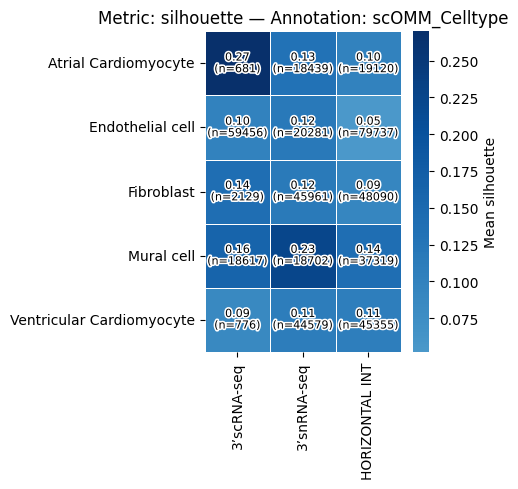

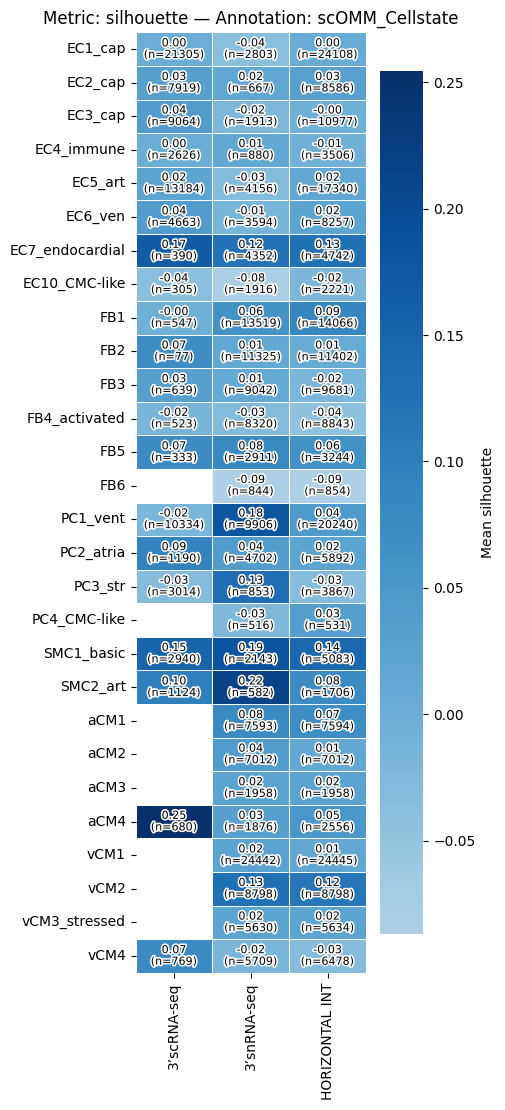

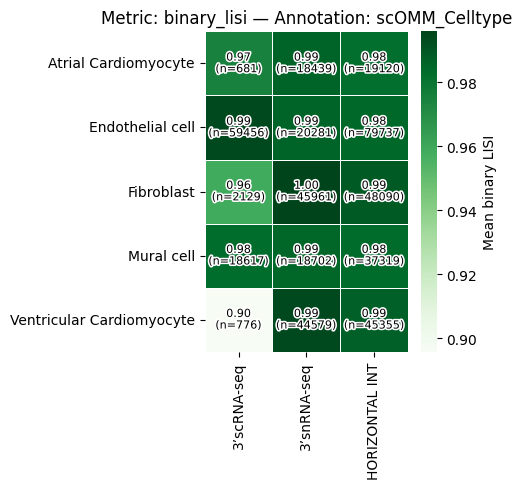

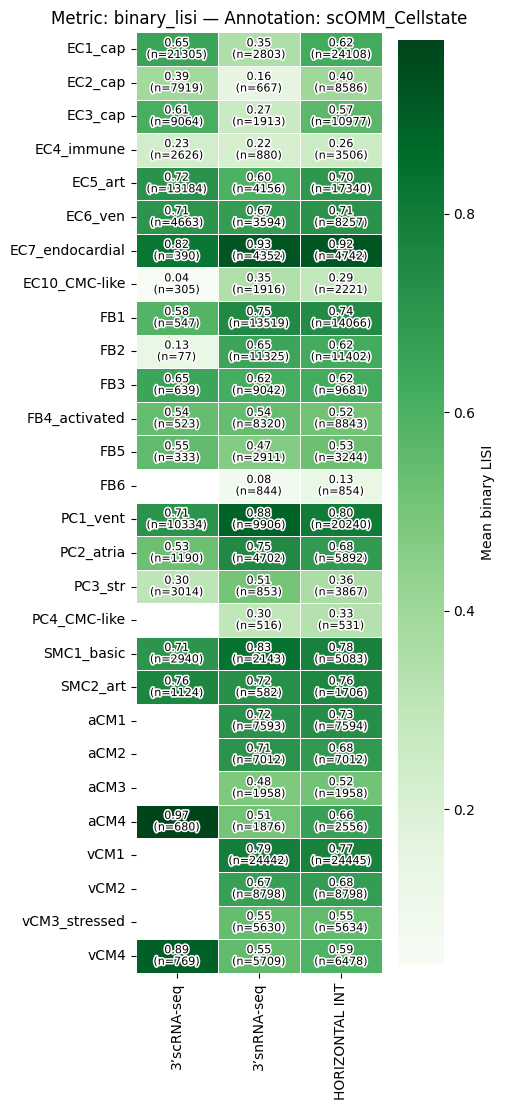

In [ ]:
techs = ['Cell_3prime-v2', 'Cell_3prime-v3',
         'Nuclei_3prime-v2', 'Nuclei_3prime-v3', 'Nuclei_Multiome-v1']

group_defs = {
    "3’scRNA-seq": ['Cell_3prime-v2', 'Cell_3prime-v3'],
    "3’snRNA-seq": ['Nuclei_3prime-v2', 'Nuclei_3prime-v3', 'Nuclei_Multiome-v1'],
}

for metric_base in ['silhouette','binary_lisi']:
    for ann in ['scOMM_Celltype','scOMM_Cellstate']:

        intercalated_mat, intercalated_cnt, _ = build_prepost_table_from_obs(
            adata,
            metric_base=metric_base,
            label_key=ann,
            tech_key="Tech",
            tech_list=techs,
            include_pre_all=True,   # queremos luego la 3ª columna "ALL"
            min_cells=10,
        )
    

        # Colapsar POST (más habitual para comparar tras integración)
        collapsed_mat, collapsed_cnt = collapse_by_tech_groups(
            intercalated_mat, intercalated_cnt,
            group_defs=group_defs,
            phase="POST",           # o "PRE" si quieres el pre-integration
            include_all=True,       # añade columna 'ALL' (se toma de PRE_ALL si existe)
            min_cells_group=None,   # o un entero si quieres apagar por grupo
        )

        plot_group_collapsed_heatmap(
            collapsed_mat, collapsed_cnt,
            metric_base=metric_base,
            title=f"Metric: {metric_base} — Annotation: {ann}",
        )

        plt.savefig(f'figs/heatmap_metrics_colapsed/{ann}_{metric_base}.png', bbox_inches='tight', dpi=400)
        plt.savefig(f'figs/heatmap_metrics_colapsed/{ann}_{metric_base}.pdf', bbox_inches='tight', dpi=400)

        if ann=='scOMM_Cellstate':
            for ct in adata.obs['scOMM_Celltype'].unique():

                intercalated_mat, intercalated_cnt, _ = build_prepost_table_from_obs(
                    adata[adata.obs['scOMM_Celltype']==ct],
                    metric_base=metric_base,
                    label_key=ann,
                    tech_key="Tech",
                    tech_list=techs,
                    include_pre_all=True,   # queremos luego la 3ª columna "ALL"
                    min_cells=10,
                )
            

                # Colapsar POST (más habitual para comparar tras integración)
                collapsed_mat, collapsed_cnt = collapse_by_tech_groups(
                    intercalated_mat, intercalated_cnt,
                    group_defs=group_defs,
                    phase="POST",           # o "PRE" si quieres el pre-integration
                    include_all=True,       # añade columna 'ALL' (se toma de PRE_ALL si existe)
                    min_cells_group=None,   # o un entero si quieres apagar por grupo
                )

                plot_group_collapsed_heatmap(
                    collapsed_mat, collapsed_cnt,
                    metric_base=metric_base,
                    title=f"Metric: {metric_base} — Annotation: {ann} - {ct} subset",
                )

                plt.savefig(f'figs/heatmap_metrics_colapsed/{ann}_{metric_base}_subset_{ct}.png', bbox_inches='tight', dpi=400)
                plt.savefig(f'figs/heatmap_metrics_colapsed/{ann}_{metric_base}_subset_{ct}.pdf', bbox_inches='tight', dpi=400)
                plt.close()
